# 3 - Hough Transform en Datos Simulados con Ruido

Los datos son electron point like, generados en el centro del detector con direcion -z e de energia 10MeV

In [1]:
from analysis_simulation import Analysis_simulation, magnitude
from modulus_simplification import GetPMTCoord

import uproot

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sn
from tqdm import tqdm
from matplotlib import style

import numpy as np
from numpy import array, where, shape, reshape, pi, cos, sin, sqrt, linspace
np.set_printoptions(threshold=1000)

from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

## 3.1 - Data Loading

In [2]:
file = uproot.open("/snoplus simulations/electron bulk/center point/simu_Analysis_elec_z_10MeV.root")

In [3]:
file.keys()

['T;1', 'pmt;2', 'pmt;1']

In [4]:
df = Analysis_simulation(file, [0,2,3,4])
df.head()

,eventID,hitpmt ID,hit type,time residual,mc coordinates,mc radius,reconst radius,reconst error,hitpmt ID hit 1,hitpmt ID hit 2,time residual hit 1,time residual hit 2,xyz hit 1,spherical hit 1,xyz hit 2,spherical hit 2
0,0,"[8977, 8612, 345, 130, 2611, 9304, 7699, 9406,...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-10262.855285398655, -103.41211156190079, 3.8...","[0.0, 0.0, 0.0]",0.0,185.545119,185.545119,"[345, 130, 2611, 9304, 7699, 9406, 6731, 286, ...","[5174, 1098, 7356, 1129, 5239, 3393, 1554, 782...","[3.869806997546192, 2.270226627645343, 5.56628...","[2.4794606286397993, 4.829957529245803, 3.2249...","[[[6668.18, 1782.97, -4799.28], [7049.55, 1754...","[[[2.1783626255075417, 0.2612727316361346, 840...","[[[5272.759999999999, 922.26, -6502.7599999999...","[[[2.4528887196313756, 0.17315862440897745, 84..."
1,2,"[2124, 4725, 8343, 4831, 8080, 559, 1072, 7764...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[13.159421608678315, 2.531283321579764, 19.853...","[0.0, 0.0, 0.0]",0.0,129.920578,129.920578,"[2124, 4725, 8343, 4831, 8080, 559, 1072, 7764...","[1937, 8265, 4771, 1616, 5995, 9418, 1592, 211...","[13.159421608678315, 2.531283321579764, 19.853...","[2.177199566410337, 1.5682771433617404, 3.0151...","[[[8179.28, 1654.9299999999998, 1018.400000000...","[[[1.4493599942093995, 0.19963684914228993, 84...","[[[5615.16, 266.8, -6251.09], [5762.7300000000...","[[[2.409174192144538, 0.04747852161922757, 840..."
2,3,"[314, 5809, 3348, 3765, 4638, 6207, 2908, 5616...","[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.8496730137599968, 5.220689772135614, 2.0454...","[0.0, 0.0, 0.0]",0.0,231.633386,231.633386,"[5809, 3348, 3765, 4638, 6207, 2908, 5616, 928...","[314, 6002, 2056, 2592, 8291, 2832, 4178, 2619...","[5.220689772135614, 2.045420372057208, 3.18573...","[0.8496730137599968, 2.2756390845492263, 4.121...","[[[6568.8, 2134.37, -4807.94], [7388.03, 2866....","[[[2.1789075611188267, 0.3141644289285388, 841...","[[[5467.54, 63.440000000000005, -6406.26999999...","[[[2.435056023684957, 0.01160250373120548, 842..."
3,4,"[8173, 4172, 5496, 7703, 3135, 2, 5489, 1163, ...","[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-93.43472440002114, 1.0648843778353125, 1.182...","[0.0, 0.0, 0.0]",0.0,258.310677,258.310677,"[4172, 5496, 7703, 3135, 2, 5489, 1163, 3725, ...","[8173, 9379, 5726, 6976, 4455, 5720, 6342, 223...","[1.0648843778353125, 1.1827966532061396, 2.629...","[-93.43472440002114, 24.229577339077196, 3.387...","[[[5615.16, 266.8, -6251.09], [7085.14, 2457.3...","[[[2.409174192144538, 0.04747852161922757, 840...","[[[5467.54, 63.440000000000005, -6406.26999999...","[[[2.435056023684957, 0.01160250373120548, 842..."


------------------------------

In [13]:
# extract the xyz_hit_coordinantes_type1 and time_residuals of ev_id = ?
ID = 0
evt_id_n = df.loc[df['eventID'] == ID]

time_residual_1 = (evt_id_n['time residual hit 1']).to_numpy()[0]
xyz_hit_1 = (evt_id_n['xyz hit 1']).to_numpy()[0][0]

pmt_id_hit = (evt_id_n['hitpmt ID']).to_numpy()[0]

In [14]:
#Compute cos(angle)
vec_ev = np.array([0.0, 0.0, -1.0])
cos_angle = np.array([])

N = shape(xyz_hit_1)[0] 
for i in range(N):
    cos_val = np.dot(xyz_hit_1[i],vec_ev)/np.linalg.norm(xyz_hit_1[i])
    cos_angle = np.append(cos_angle, cos_val)

In [15]:
len(time_residual_1)

126

Innecesario! solo quiero el hit type 1, que ya esta en el analisis de la simulacion!

In [16]:
pmt_hit_1_coord = GetPMTCoord(file, pmt_id_hit_1)
pmt_hit_1_coord.head()

,x,y,z,zenit,azimut,rad
0,5272.76,922.26,-6502.76,2.452889,0.173159,8422.496610
1,6773.45,1974.38,-4600.32,2.148600,0.283630,8422.632925
2,6668.18,1782.97,-4799.28,2.178363,0.261273,8406.943264
3,6817.22,1212.37,-4767.84,2.173815,0.175999,8406.939265
4,6712.07,1021.37,-4966.88,2.202398,0.151011,8412.192181


------------------------------

## 3.2 Time Residual Cuts

In [63]:
inf_cut = -5
up_cut = 15

time_residual_1_cut = np.array([]) 
xyz_hit_cut = np.array([])
cos_angle_cut = np.array([])                                  

#cuts
for i in np.where((np.array(time_residual_1) > inf_cut) & (np.array(time_residual_1) < up_cut))[0]:
    time_residual_1_cut = np.append(time_residual_1_cut, time_residual_1[i])
    xyz_hit_cut = np.append(xyz_hit_cut, xyz_hit_1[i])
    cos_angle_cut = np.append(cos_angle_cut, cos_angle[i])
    
xyz_hit_cut = xyz_hit_cut.reshape(-1,3)

In [64]:
len(time_residual_1_cut)

85

### 3.2.1 $\alpha$ angle and time residual

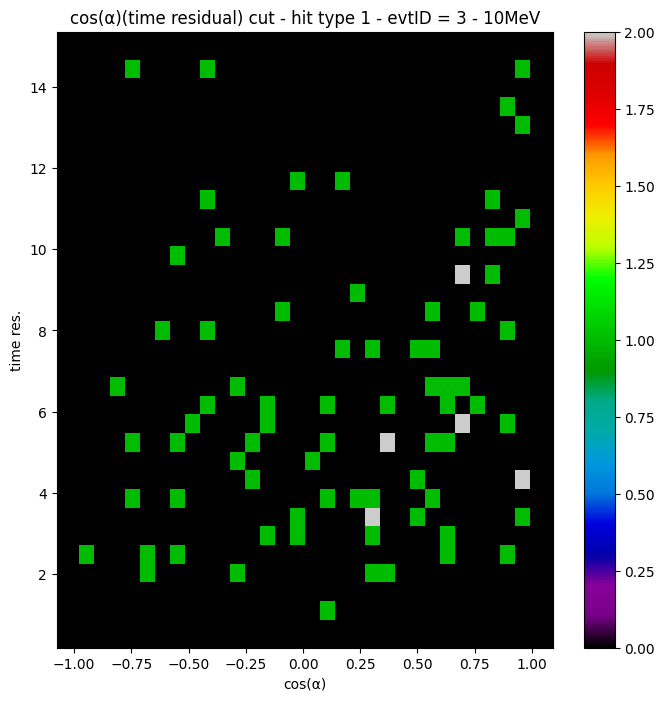

In [57]:
title = 'cos(α)(time residual) cut - hit type 1 - evtID = 3 - 10MeV'

plt.figure(figsize=(8,8))
sn.set_style(rc = {'axes.facecolor': 'black'})
sn.histplot(x = cos_angle_cut, y = time_residual_1_cut, bins = [30,30], stat='count', cbar = 'True', cmap = cm.nipy_spectral)
plt.ylabel('time res.')
plt.xlabel('cos(α)')
plt.title(title)

#equal acis ration
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.show()

### 3.2.2 xyz hit distribution

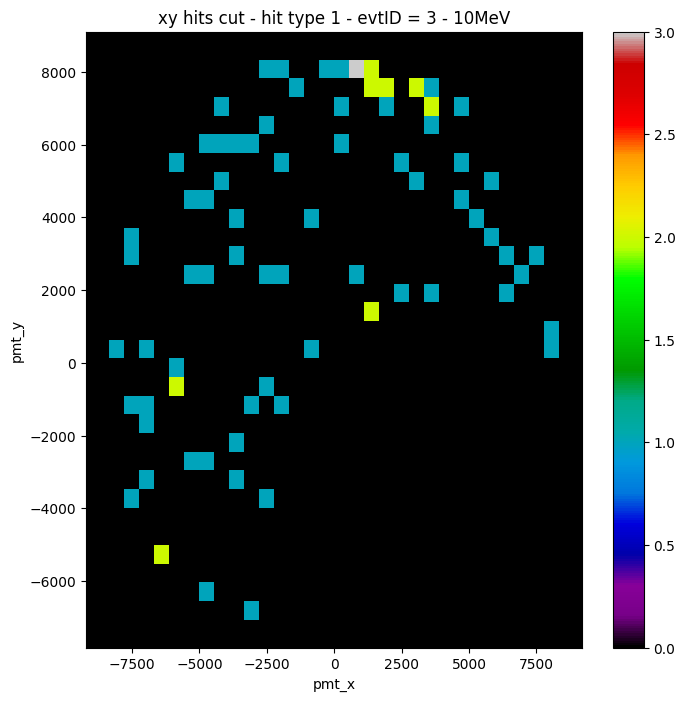

In [103]:
x_cut = xyz_hit_cut[:,0]
y_cut = xyz_hit_cut[:,1]
z_cut = xyz_hit_cut[:,2]

title = 'xy hits cut - hit type 1 - evtID = 3 - 10MeV'

plt.figure(figsize=(8,8))
sn.set_style(rc = {'axes.facecolor': 'black'})
sn.histplot(x = x_cut, y = y_cut, bins = [30,30], stat='count', cbar = 'True', cmap = cm.nipy_spectral)
plt.ylabel('pmt_y')
plt.xlabel('pmt_x')
plt.title(title)

#equal acis ration
#ax = plt.gca()
#ax.set_aspect('equal', adjustable='box')
plt.show()

## 3.2 Hough Transform with time cuts

In [104]:
len(x_cut)

85

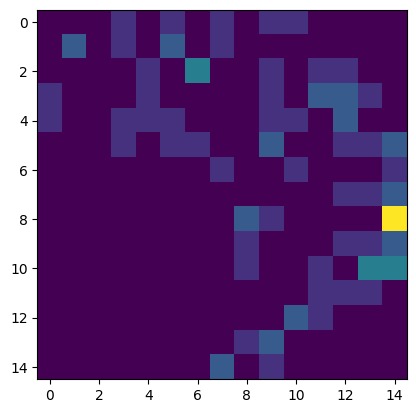

In [124]:
bins = 15
imag_xyz, _, _ = np.histogram2d(x = x_cut, y = y_cut, bins = [bins, bins])
plt.imshow(imag_xyz)

In [125]:
result_xyz = hough_ellipse(imag_xyz, accuracy = 0.5, threshold = 4)

In [126]:
# ordenar por acumulador creciente
result_xyz.sort(order = 'accumulator')

#mejor acumulador
best = list(result_xyz[-1])
best

[8, 7.5, 7.5, 5.70087712549569, 5.70087712549569, 2.480549484739106]

In [127]:
#extraer paramentos de elipse
yc, xc, a, b = (int(round(x)) for x in best[1:5]) #iterate over best[1:5]
orientation = best[5]

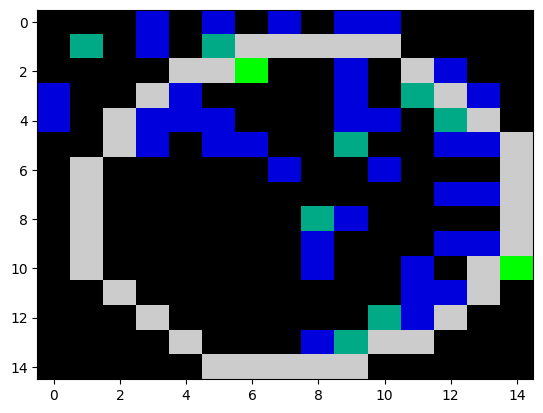

In [128]:
# extraer parametros de elipse
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
#cy, cx -> Index of pixels that belong to the ellipse perimeter

# Resaltar pixeles en la imagen original de modo a ver la elipse reconstruida
imag_xyz[cy,cx] = 5

plt.imshow(imag_xyz, cmap = cm.nipy_spectral, aspect = 'auto')
plt.show()